# Style Transfer предобученной сетью посредством Vulkan layer.

@ettavolt & @unfinity

Идея проекта взята из
[записи в блоге Stadia](https://stadia.dev/blog/behind-the-scenes-with-stadias-style-transfer-ml/).

Обучение широкообобщающей сети (т.е. способной переносить любой, в т.ч. незнакомый, стиль) -
вычислительно очень сложная задача. Потому для начала целесообразно настроить и интегрировать сеть,
умеющую переносить только один стиль.

[TL;DR](https://rg.ettavolt.nl/dav/public/dlschool.final/)

Незавершённые наработки по реализации Vulkan layer
доступны в [хранилище на GitHub](https://github.com/ettavolt/vkBasalt/tree/uniform-dynamic-buffers).

## Обучение

In [1]:
%matplotlib inline

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, Sampler
from torchvision.transforms.functional import to_tensor, to_pil_image

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Going to compute with {DEVICE}")

def load_image(path: Path):
    with Image.open(path) as img:
        return to_tensor(img.convert('RGB'))

def show_tensor(t: torch.Tensor, plt_ax=plt, title=''):
    for_plt = t.permute((1, 2, 0))
    plt_ax.imshow(for_plt)
    plt_ax.set_title(title)
    plt_ax.grid(False)

def compare_tensors(t1, t2):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
    show_tensor(t1, ax[0])
    show_tensor(t2, ax[1])

class ImageDataset(Dataset):
    def __init__(self, paths):
        self._paths = paths
    def __getitem__(self, index):
        return load_image(self._paths[index])
    def __len__(self):
        return len(self._paths)

class SubsetSampler(Sampler):
    def __init__(self, indices):
        super().__init__(indices)
        self.indices = indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self)-> int:
        return len(self.indices)

Going to compute with cuda


Возьмём обрезанную и сжатую картинку стиля
и сжатые без сохранения пропорций картинки из COCO 2017 validation dataset.
```
find val2017 -type f -printf '%f\0' |\
xargs -0 -P 4 -n 1 -I% gm convert val2017/% -geometry '300x300!' -quality 90 coco-square/%
```

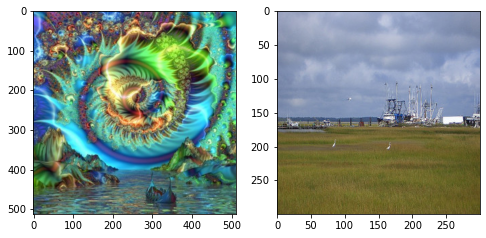

In [2]:
style_image = load_image(Path("s1.png"))
all_dataset = ImageDataset(sorted(list(Path("coco-square").rglob('*.jpg'))))
compare_tensors(style_image, all_dataset[34])

Жадно разделим на обучающую и контрольную выборки.

В дальнейшем будут использованы лишь небольшие части этого набора,
т.к. нет необходимости в широком обощении, а основным критерием качества является визуальная привлекательность.
Для оценки которой используется биологическая нейронная сеть.

In [3]:
import numpy as np

np.random.seed(42)
val, tr = np.split(np.random.choice(len(all_dataset), len(all_dataset), False), [100])
print(len(tr), len(val), len(all_dataset))

4900 100 5000


Ниже представлен преимущественно инфраструктурный код.

Класс `Learner` представляет собой типизированную структуру,
которая существенно облегчает обучение нескольких экземпляров сети.

Значение ф.потерь формируется функциями `gram`, `criterion`.
В последней реализована нормировка стилевых и структурных частей
путём взятия частного от деления на сумму квадратов элементов, составляющих целевые матрицы:
Грама или структуры соотвествующего уровня.

In [4]:
import torch.nn as nn
import torch.nn.functional as nn_f
from IPython.display import clear_output
from tqdm import tqdm
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.models.vgg import vgg16_bn

BATCH_SIZE = 4
WORKERS = 4

def gram(t: torch.Tensor):
    nb, nc, h, w = t.size()
    t_linear = t.view(nb, nc, h * w)
    # Need to divide by image size to support transfering between different-sized content and style.
    return t_linear.matmul(t_linear.transpose(1, 2)).true_divide(h * w)

# To avoid polluting global scope with barely distiguishable variables.
class Learner:
    persistent = ['epochs', 'epoch', 'best_epoch', 'best_val_loss', 'history', 'batch_size', 'num_workers', 'style_to_content', 'style_idxes', 'content_idx']
    def __init__(self, model: nn.Module, name=None, dataset=all_dataset, train_idx=tr, val_idx=val):
        self.name = f"{type(model).__name__}" if name is None else name
        self.epochs = 40
        self.epoch = 0
        self.best_epoch = 0
        self.best_val_loss = None
        self.history = []
        self.batch_size = BATCH_SIZE
        self.num_workers = WORKERS
        self.model = model
        self.dataset = dataset
        self.train_idx = train_idx
        self.val_idx = val_idx
        self.saves_path = Path(f"saves/{self.name}")
        self.saves_path.mkdir(parents=True, exist_ok=True)
        self.visualize_val_idx = []
        self.visualize_val_preds = []
        layers = vgg16_bn(pretrained=True).eval().features
        layers.to(DEVICE)
        self.image_net_coefs = torch.as_tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=DEVICE).view(1, 3, 1, 1)
        self.image_net_stds = torch.as_tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=DEVICE).view(1, 3, 1, 1)
        self.convs = [c for c in layers.children() if isinstance(c, nn.Conv2d)]
        self.bns = [c for c in layers.children() if isinstance(c, nn.BatchNorm2d)]
        self.pool_idxes = [i for i, c in enumerate(layers.children()) if isinstance(c, nn.MaxPool2d)]
        # We compare with a counter over convs, need to compensate an index
        # by a factor of 3 (Conv+BN+ReLU), substracting a number of previous pool layers.
        # Also deduct 1 for this layer itself
        layers_in_block = 3 if len(self.bns) > 0 else 2
        self.pool_idxes = [(idx - ctr) // layers_in_block - 1 for ctr, idx in enumerate(self.pool_idxes)]
        self.style_to_content = 2E1
        self.style_idxes = [0, 2, 4, 7, 10, -1]
        self.style_grams = []
        self.style_gram_coefs = []
        self.content_idx = 8
        self.device = DEVICE
        return
    def __setattr__(self, key, value):
        object.__setattr__(self, key, value)
        if key == 'device':
            self.model.to(value)
            self.image_net_coefs = self.image_net_coefs.to(device=value)
            self.image_net_stds = self.image_net_stds.to(device=value)
            for m in self.convs:
                m.to(value)
            for m in self.bns:
                m.to(value)
            self.style_grams = [m.to(value) for m in self.style_grams]
            self.style_gram_coefs = [m.to(value) for m in self.style_gram_coefs]
        return

def create_loader(learner: Learner, sampler: torch.utils.data.Sampler):
    return DataLoader(
        learner.dataset,
        sampler=sampler,
        batch_size=learner.batch_size,
        num_workers=learner.num_workers,
        pin_memory=True,
    )

def forward(learner: Learner, t: torch.Tensor, conv_consumer):
    pool_ctr = 0
    t = t.sub(learner.image_net_coefs).true_divide(learner.image_net_stds)
    for layer_ctr in range(0, len(learner.convs)):
        t = learner.convs[layer_ctr](t)
        if conv_consumer(t, layer_ctr):
            break
        if len(learner.bns) > 0:
            t = learner.bns[layer_ctr](t)
        t = nn_f.relu(t)
        if layer_ctr == learner.pool_idxes[pool_ctr]:
            # They say avg vs max gives better-appealing results, even for pretrained VGG.
            t = nn_f.avg_pool2d(t, kernel_size=2, stride=2)
            pool_ctr += 1

def learn_style(learner: Learner, style_t: torch.Tensor, style_idxes=None):
    n_layers = len(learner.convs)
    if style_idxes is not None:
        ioob = [idx for idx in style_idxes if idx >= n_layers]
        if len(ioob) > 0:
            raise Exception(f"{ioob} are out of bounds, maximum index is {n_layers - 1}")
        # Add -1 to simplify finish checks
        learner.style_idxes = style_idxes + [-1]
    learner.style_grams = []
    learner.style_gram_coefs = []
    with torch.no_grad():
        if len(style_t.size()) == 3:
            style_t = style_t.unsqueeze(0)
        style_ctr = 0
        def closure(res, layer_ctr):
            nonlocal style_ctr
            if layer_ctr == learner.style_idxes[style_ctr]:
                style_gram = gram(res)
                learner.style_grams.append(style_gram)
                learner.style_gram_coefs.append(
                    style_gram.square().sum(dim=(1, 2)).pow(-1.0)
                )
                style_ctr += 1
            return learner.style_idxes[style_ctr] == -1
        forward(learner, style_t.to(learner.device), closure)

def criterion(learner: Learner, unstyled: torch.Tensor, styled: torch.Tensor):
    style_ctr = 0
    loss = torch.zeros(1, device=DEVICE)
    loss_parts = []
    def closure(res: torch.Tensor, layer_ctr: int):
        nonlocal style_ctr
        nonlocal loss
        nonlocal loss_parts
        if layer_ctr == learner.content_idx:
            unstyled_content: torch.Tensor
            styled_content: torch.Tensor
            unstyled_content, styled_content = res.chunk(2)
            content_features_coef = unstyled_content.square().sum(dim=(1,2,3))
            content_loss = styled_content\
                .add(unstyled_content, alpha=-1)\
                .square()\
                .sum(dim=(1,2,3))\
                .true_divide(content_features_coef)\
                .sum()
            loss += content_loss
            loss_parts.append(content_loss.item())
        if layer_ctr == learner.style_idxes[style_ctr]:
            style_gram = learner.style_grams[style_ctr]
            style_loss = gram(res.chunk(2)[1])\
                .add(style_gram, alpha=-1)\
                .square()\
                .sum(dim=(1,2))\
                .mul(learner.style_gram_coefs[style_ctr])\
                .sum()
            loss = loss.add(
                style_loss,
                alpha=learner.style_to_content
            )
            loss_parts.append(style_loss.item())
            style_ctr += 1
        return layer_ctr >= learner.content_idx and learner.style_idxes[style_ctr] == -1
    forward(learner, torch.cat([unstyled, styled]), closure)
    return loss, loss_parts

def run_batches(learner: Learner, loader, lr_sched, do_train):
    with torch.set_grad_enabled(do_train):
        learner.model.train(do_train)
        running_loss = 0.0
        # style_idxes has terminating -1, that we count as content part here.
        parts = [0.0 for _ in learner.style_idxes]
        processed_count = 0
        opt = lr_sched.optimizer

        batches = tqdm(
            loader,
            desc=('Train E{}' if do_train else 'Validate E{}').format(learner.epoch + 1),
            unit='batch',
            leave=False
        )
        if not do_train:
            learner.visualize_val_preds = []
        for inputs in batches:
            this_batch_size = inputs.size(0)
            inputs = inputs.to(learner.device)

            with torch.autograd.set_detect_anomaly(False):
                outputs = learner.model(inputs)
                loss_value, loss_parts = criterion(learner, inputs, outputs)
                if do_train:
                    opt.zero_grad()
                    loss_value.backward()
                    opt.step()
                else:
                    # While it is possible to leverage a list comprehension
                    # to find which indexes (in current input) we are interested in
                    # it's much simpler to just iterate over these six numbers
                    for wanted_val_idx in learner.visualize_val_idx:
                        wanted_val_idx -= processed_count
                        if wanted_val_idx >= this_batch_size:
                            break
                        if wanted_val_idx < 0:
                            continue
                        learner.visualize_val_preds.append(outputs[wanted_val_idx].cpu())
            running_loss += loss_value.item()
            for i, part in enumerate(loss_parts):
                parts[i] += part
            processed_count += this_batch_size
        if not do_train:
            lr_sched.step(running_loss / processed_count)

    return [running_loss / processed_count, [p / processed_count for p in parts]]

def train(learner: Learner, init_lr=1E-3):
    if learner.epoch >= learner.epochs:
        raise Exception(f"Already passed through epoch #{learner.epoch}, increase the maximum (currently {learner.epochs})" )
    learner.visualize_val_idx = list(np.random.permutation(len(learner.val_idx))[0:6])
    learner.visualize_val_idx.sort()

    torch.random.manual_seed(42)
    train_loader = create_loader(learner, SubsetRandomSampler(learner.train_idx))
    val_loader = create_loader(learner, SubsetSampler(learner.val_idx))

    opt = torch.optim.AdamW(
        [p for p in learner.model.parameters() if p.requires_grad == True],
        lr=init_lr,
    )
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        factor=0.5,
        patience=2,
        threshold=1e-2,
        verbose=True
    )
    # sched = torch.optim.lr_scheduler.StepLR(
    #     opt,
    #     step_size=int(epochs / log(1E-2) * log(0.2)),
    #     gamma=0.2
    # )
    for epoch in range(learner.epoch, learner.epochs):
        epoch += 1
        history_entry = []
        for do_train in (True, False):
            subepoch_stats = run_batches(
                learner,
                train_loader if do_train else val_loader,
                lr_sched,
                do_train,
            )
            history_entry += subepoch_stats

        learner.epoch = epoch
        learner.history.append(history_entry)
        visualize_last_epoch(learner)
        if learner.best_val_loss is None or history_entry[2] < learner.best_val_loss:
            learner.best_val_loss = history_entry[2]
            learner.best_epoch = epoch

        save_epoch(learner)
    print(
        f"Best epoch is {learner.best_epoch} "
        f"with loss={learner.best_val_loss} "
        f"and metric={learner.history[learner.best_epoch - 1][3]} "
        f"on validation set"
    )
    return

def visualize_last_epoch(learner: Learner):
    columns = len(learner.visualize_val_preds)
    if columns < 0:
        raise Exception("visualize_val_preds is empty, nothing to visualize")
    columns_from_indexes = len(learner.visualize_val_idx)
    if columns != columns_from_indexes:
        raise Exception(f"visualize_val_preds has {columns} elements and visualize_val_idx - {columns_from_indexes}")
    clear_output(wait=True)
    plt.figure(figsize=(15, 6))
    with torch.no_grad():
        for vis_ctr, val_sample_idx in enumerate(learner.visualize_val_idx):
            input_img = learner.dataset[learner.val_idx[val_sample_idx]]
            plt.subplot2grid((2, columns), (0, vis_ctr))
            plt.imshow(np.rollaxis(input_img.numpy(), 0, 3))
            plt.title('Content')
            plt.axis('off')

            styled = learner.visualize_val_preds[vis_ctr].permute((1, 2, 0))
            plt.subplot2grid((2, columns), (1, vis_ctr))
            plt.imshow(styled)
            plt.title('Styled')
            plt.axis('off')
        history_entry = learner.history[-1]
        train_parts = ", ".join(f"{p:.4E}" for p in history_entry[1])
        val_parts = ", ".join(f"{p:.4E}" for p in history_entry[3])
        plt.suptitle(
            f"Epoch {learner.epoch:#03d}/{learner.epochs:#03d} "
            f"Train Loss: {history_entry[0]:#0.4f} "
            f"Val Loss: {history_entry[2]:#0.4f}\n"
            f"Train Loss Parts: {train_parts}\n"
            f"Val Loss Parts: {val_parts}"
        )
        plt.show()

def visualize_epochs(learner: Learner):
    train_loss, train_loss_parts, val_loss, val_loss_parts = zip(*learner.history)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1, 2, 2)
    train_loss_parts = list(zip(*train_loss_parts))
    val_loss_parts = list(zip(*val_loss_parts))
    colors = ['r', 'y', 'g', 'c', 'k', 'm']
    for i, part in enumerate(train_loss_parts):
        plt.plot(part, colors[i] + '-', label='Train S1 Loss' if i == 0 else None)
        plt.plot(val_loss_parts[i], colors[i] + ':', label='Val S1 Loss' if i == 0 else None)
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.legend()
    plt.show()

def load_epoch(learner: Learner, epoch):
    if isinstance(epoch, int):
        path_to_state = learner.saves_path.joinpath(f"e{epoch:#03d}.pth")
    elif isinstance(epoch, str):
        path_to_state = epoch
    else:
        raise Exception(f"Can't load state from {epoch}")
    if isinstance(path_to_state, str) and path_to_state.startswith("http"):
        saved_state = torch.hub.load_state_dict_from_url(path_to_state, map_location='cpu')
    else:
        saved_state = torch.load(path_to_state, map_location='cpu')
    for field in Learner.persistent:
        setattr(learner, field, saved_state['learner_state_dict'][field])
    learner.model.load_state_dict(saved_state['model_state_dict'])
    learner.model.to(learner.device)
    return

def save_epoch(learner: Learner):
    learner_state = {}
    for field in learner.persistent:
        learner_state[field] = getattr(learner, field)
    torch.save(
        {
            'learner_state_dict': learner_state,
            'model_state_dict': learner.model.state_dict(),
        },
        learner.saves_path.joinpath(f"e{learner.epoch:#03d}.pth")
    )

def style_one_image(learner: Learner, image_tensor):
    """Стилизация одной картинки"""
    with torch.no_grad():
        learner.model.eval()
        return learner.model(image_tensor.unsqueeze(0).to(learner.device)).squeeze(0).cpu()

За основу архитектуры взято описание из вышеупомянутого блога
(с деталями из [оригинальной статьи](https://arxiv.org/abs/1705.06830)).
Первый и последний свёрточные слои заменены на не-separable версию с целью лучшего сохранения деталей.

In [9]:
class ResidualSeparableBlock(nn.Module):
    def __init__(self, features, kernel=3, padding=1, padding_mode='reflect', **kwargs):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
            nn.ReLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
        )

    def forward(self, x):
        return self.conv_2(self.conv_1(x)) + x


def conv_separable_block(in_features, out_features, kernel=3, stride=2, padding=1, padding_mode='reflect', **kwargs):
    mid_features = out_features // in_features * in_features
    return nn.Sequential(
        nn.Conv2d(
            in_features,
            mid_features,
            kernel,
            stride=stride,
            padding=padding,
            padding_mode=padding_mode,
            groups=in_features,
            **kwargs
        ),
        nn.Conv2d(mid_features, out_features, 1, bias=False),
        nn.InstanceNorm2d(out_features, affine=True),
        nn.ReLU(),
    )


def upconv_separable_block(in_features, out_features, bias=True, kernel=3, stride=2, padding=1, output_padding=1, **kwargs):
    mid_features = in_features // out_features * out_features
    return nn.Sequential(
        nn.ConvTranspose2d(in_features, mid_features, 1),
        nn.ConvTranspose2d(
            mid_features,
            out_features,
            kernel,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            groups=out_features,
            bias=bias,
            **kwargs
        ),
    )


class Activate(nn.Module):
    def forward(self, input: torch.Tensor):
        # return input.clamp(0.0, 1.0)
        return input.tanh().add(1).true_divide(2)


class StyleTransferFast3(nn.Module):
    def __init__(self, n_residual=15):
        super().__init__()
        self.n_residual = n_residual
        residual_stack = [ResidualSeparableBlock(64) for _ in range(self.n_residual)]
        self.layers = nn.Sequential(
            conv_separable_block(3, 16),
            conv_separable_block(16, 64),
            *residual_stack,
            upconv_separable_block(64, 16),
            nn.ReLU(),
            upconv_separable_block(16, 3),
            Activate()
        )

    def forward(self, x):
        return self.layers(x)

In [18]:
fast_learner = Learner(StyleTransferFast3(), train_idx=tr[0:500], val_idx=val[0:12], name="StyleTransferFast3")

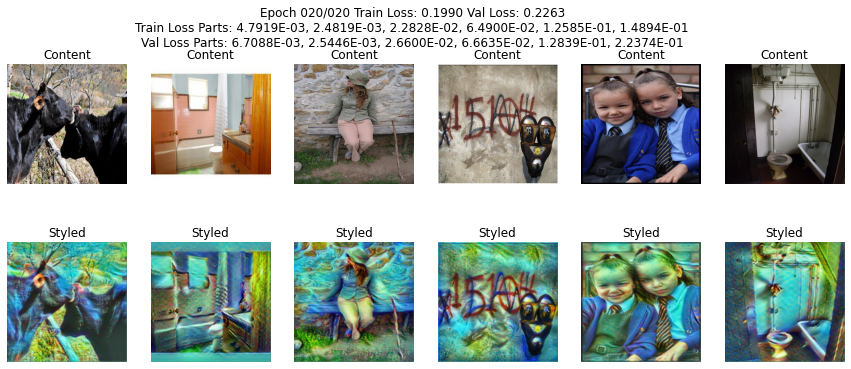

Best epoch is 20 with loss=0.22626191874345145 and metric=[0.006708809640258551, 0.0025445555026332536, 0.026599602152903874, 0.06663477420806885, 0.1283936152855555, 0.22373990217844644] on validation set


In [19]:
# load_epoch(fast_learner, 20)
fast_learner.style_to_content = 30E-2
fast_learner.epochs = 20
learn_style(fast_learner, style_image)
# fast_learner.style_gram_coefs[3].mul_(2)
# fast_learner.style_gram_coefs[4].mul_(2)
train(fast_learner, 2E-2)

Нормировка оказалась очень удачной. Попытки увеличить вклад высокоуровневых стилей
привели лишь к появлению высококонтрастного "блуждающего штриха",
никак не связанного с низлежащей структурой.

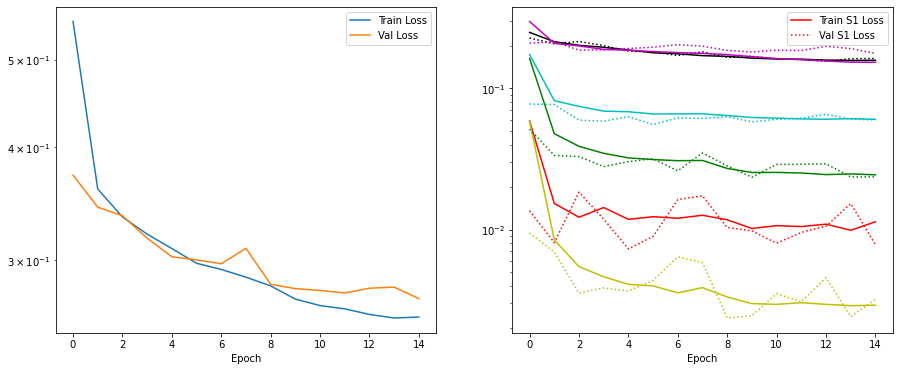

In [15]:
visualize_epochs(fast_learner)

Правый график отражает изменение частей ф.потерь в течение обучения:

1. Стилевая 1-го уровня: красные линии.
1. Стилевая 2-го уровня: жёлтые линии.
1. Стилевая 3-го уровня: зелёные линии.
1. Стилевая 4-го уровня: голубые линии.
1. Стилевая 5-го уровня: пурпурные линии.
1. Структурная: чёрные линии.

Так же разучим второй стиль.

In [8]:
style_image2 = load_image(Path("s2.png"))
fast_learner_s2 = Learner(StyleTransferFast3(), name="StyleTransferFast-s2", train_idx=tr[0:500], val_idx=val[0:12])

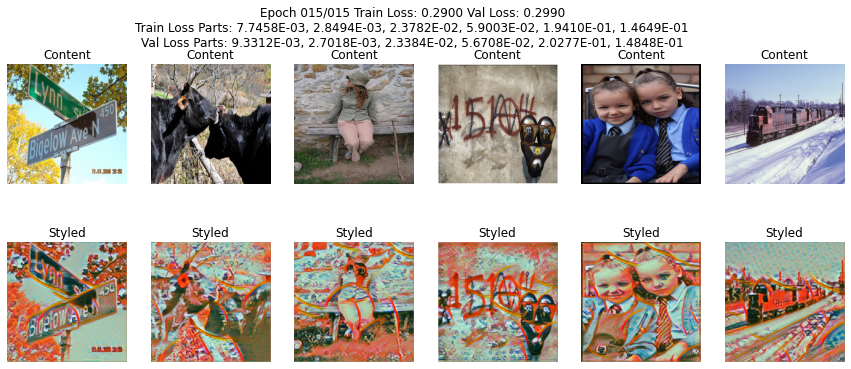

Best epoch is 13 with loss=0.2908075948556264 and metric=[0.00763209272796909, 0.0022258481476455927, 0.021679974471529324, 0.05120266725619634, 0.19833981494108835, 0.1484288771947225] on validation set


In [9]:
fast_learner_s2.style_to_content = 4E-1
fast_learner_s2.epochs = 15
learn_style(fast_learner_s2, style_image2)
train(fast_learner_s2, 2E-2)

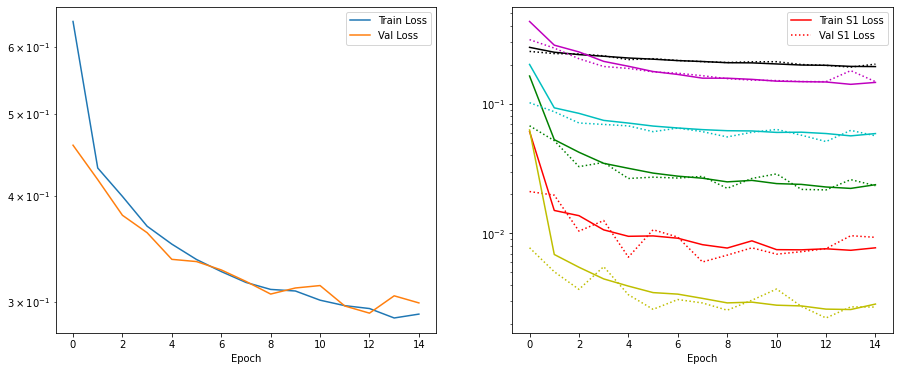

In [11]:
visualize_epochs(fast_learner_s2)

Ввиду большого количества деталей сеть выучила преимущественно красные линии.

Стилизуем несколько изображений (в т.ч. исходные для определяющих стиль картинок)
с помощью полученных сетей.

In [13]:
load_epoch(fast_learner, 15)
# load_epoch(fast_learner_s2, 15)

In [20]:
%%time

for sPath in """demo/battle.jpg
demo/age-majority-day.jpg
demo/workers.jpg
demo/fear.jpg
demo/sansara-wheel.jpg
demo/rainbow-shell.jpg
demo/papirus.04.jpg
demo/scarab.jpg
demo/bieber.jpg
demo/siren.jpg
demo/metro.png
demo/gator.jpg
demo/medieval-ruins.jpg""".split("\n"):
    path = Path(sPath)
    content = load_image(path)
    content_s = style_one_image(fast_learner, content)
    to_pil_image(content_s).save(path.with_suffix(".s1.3.jpg"))
    # content_s = style_one_image(fast_learner_s2, content)
    # to_pil_image(content_s).save(path.with_suffix(".s2.jpg"))

CPU times: user 8.92 s, sys: 792 ms, total: 9.72 s
Wall time: 8.58 s


Результат доступен [здесь](https://rg.ettavolt.nl/dav/public/dlschool.final/).

Судя по user CPU time, боˊльшую часть нагрузки создала PIL, выполняя кодирование результатов при сохранении.